# Answer the F Question

## 1. 导入所需要的库

In [1]:
# 基本库
import os
import datetime
import time

# 数据读取
import pandas as pd
import numpy as np

# 可视化
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from matplotlib import cm
import seaborn as sns

# 操作Excel表格
# 只用读取即可。
import xlrd

# 地图显示
from pyecharts.charts import Bar
import pandas as pd
from pyecharts.charts import Map, Geo
from pyecharts import options as opts

# 用于调用地图API
import json
import requests
import geopy
from geopy.geocoders import Nominatim

# import tensorflow as tf

# import dgl

## 2 定义公共函数

输出信息

In [2]:
def DisplayStartInfo():
    """
    :description: 显示开始时间。
    :param None {type: None}: 
    :return startTime {type: datetime.datetime}{count: 1}: 返回当前时间。
    """
    print("-------------------------Start-------------------------")
    startTime = datetime.datetime.now()
    print(startTime.strftime('%Y-%m-%d %H:%M:%S'))
    return startTime


def DisplayCompletedInfo(startTime=datetime.datetime.now(), isDisplayTimeConsumed=False):
    """
    :description: 显示结束时间信息。
    :param startTime {type: datetime.datetime} {default: datetime.datetime.now()}:: 显示开始时间。default值搭配着isDisplayTimeConsumed=False一起使用，这个时候可以不输出消耗时间。
    :param isDisplayTimeConsumed {type: bool} {default: False}: 是否显示消耗的时间，默认值不显示。
    :return None {count: 0}: 
    """
    if isDisplayTimeConsumed==True:
        print('Time consumed:', str(datetime.datetime.now() - startTime).split('.')[0])
    print("Completed at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ".\n")
    print("-------------------------Completed-------------------------")

def DisplaySeparator():
    print("---------------------------------------------------------\n")

In [3]:
DisplayCompletedInfo()

Completed at 2022-10-08 23:29:26.

-------------------------Completed-------------------------


可视化设置

In [4]:
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [5]:
# 设置字体
# STFANGSO.TTF字体需要拷贝。在没有STFANGSO.TTF的情况下，可以使用windows默认字体simsun.ttc。
myFont = fm.FontProperties(fname='c:\windows\Fonts\STFANGSO.TTF')
# myFont = fm.FontProperties(fname='c:\windows\Fonts\simsun.ttc')

# 设置图像大小
figSizeNormal = (5, 3.09)
figSizeHuge = (8, 8)


def setRainbowColors(valueList):
    """_summary_ 设置饼图的彩虹色

    Args:
        valueList (list): 输入值的列表。

    Returns:
        list: 彩虹色的列表。
    """
    return cm.rainbow_r(np.arange(len(valueList))/len(valueList))

def make_autopct(values_list):
    def my_autopct(pct):
        total = sum(values_list)
        val = int(round(pct*total)/100.0)
        return '{p:1.1f}% ({v:d}人)'.format(p=pct, v=val)
    return my_autopct

# 首先计算百分比
def calculatePercentage(inputList):
    percentageList = []
    total = sum(inputList)
    for temp in inputList:
        percentageList.append(round((temp/total * 100.0),1))
    return percentageList

生成单个柱状图

In [6]:

def drawingSingBar(data_df, title, x_column_name, y_column_name, 
                   xlabel, ylabel, label_name, path, imageSize=(6, 6), ShowEnable=True):
    """_summary_ 绘制单个柱状图。

    Args:
        data_df (Pandas.Dateframe): 包含显示信息的Dataframe数据集。
        title (string): 图的名称。
        x_column_name (string): x轴在数据集中的列名。
        y_column_name (string): y轴在数据集中的列名。
        xlabel (string): x轴标签名。
        ylabel (string): y轴标签名。
        label_name (string): 图例的名称。
        path (string): 保存路径。
        imageSize (tuple, optional): 图片整体大小. Defaults to (6, 6).
        ShowEnable (boolean, optional): 图片是否显示在jupyter中。
                                        如果false就只保存，不展示结果。Defaults to True.
    """
    x = data_df[x_column_name]
    y = data_df[y_column_name]
    fig = plt.figure(figsize=imageSize, dpi=80)
    ax = fig.add_subplot(111)
    ax.plot(x, y, label=label_name)
    tick_spacing = 180
    plt.xticks(rotation=45)
    plt.xlabel(xlabel, fontproperties=myFont)
    plt.ylabel(ylabel, fontproperties=myFont)
    plt.title(title)
    plt.grid(alpha=0.4)
    plt.legend(prop=myFont, loc='upper left')
    plt.savefig(path)
    if ShowEnable == True:
        plt.show()
    plt.clf()
    plt.close()

## 3. 数据读取及数据预处理

将所有excel中的数据按日期读取出来，并统一建议按种类分布的表。

## 3.1 文件批量改名

|编号|数据名称|重命名英文名称|说明|
|---|---|---|---|
|1|附件1：长春市COVID-19疫情期间病毒感染人数数据-新增本土感染者|1nlip|1New Local Infected Persons|
|2|附件1：长春市COVID-19疫情期间病毒感染人数数据-新增无症状感染者|1nai|1New Asymptomatic Infections|
|3|附表2：长春市9个区隔离人口数量与生活物资投放点数量|2pndpl|2Population and Number of Distribution Points of LivingMaterials|
|4|交通路口节点数据|3tind|Traffic intersection node data|
|5|交通路口路线数据|3tird|Traffic intersection route data|
|6|各区主要小区数据|3dmced|Data of main communities in each district|
|7|附件3/1.XX月XX日长春市重点民生商品供应情况表(0316模板）|31sklc|Supply of Key Livelihood Commodities|
|8|附件3/2.长春市生活物资保障体系基本情况表|32bilmss|Basic Information of Living Material Support System|
|9|附件3/3.XX月XX日长春市主要粮油副食品零售价格监测表|33rpmconsf|Monitoring Table for Retail Price of Major Cereals, Oils and Non staple Foods|
|10|附件3/4.XX月XX日长春市重点蔬菜零售价格监测表|34rpkv|Monitoring Table for Retail Price of Key Vegetables|
|11|附件3/5.点调重点企业主要生活必需品价格情况表|35pmnke|Price of main necessities of key enterprises|
|12|附件3/|||
|13||||
|14||||
|15||||
|16||||
|||||
|||||
|||||

1. “4月29日”是一个关键节点，同名的文件夹有2个数据。一份是正常的日报；另一份是复工情况报告，这一份重名为“4月29日fg”。
2. 一共有352个xls/xlsx文件。
3. 重点民生商品供应情况表共计57个。
4. 重点民生商品供应情况表 中定义列数有28列。定义行数为65行（也就是65天排除了4月29日fg这个文件夹）。
   1. 列名
      |编号|名称|英文|说明|
      |---|---|---|---|
      |1|粮食总储备量|gtr|Total grain reserves|
      |2|粮食政府储备|ggr|Grain government reserves|
      |3|粮食重点企业库存|gike|Inventory of key grain enterprises可以为空|
      |4|粮食日出库量|gdo|Daily grain output|
      |5|粮食日进货量|gdp|Daily grain purchase|
      |6|粮食保障天数|gsd|Grain security days|
      |7|粮食储备标准|grs|Grain reserve standard|
      |8|食用油总储备量|otr|Oil|
      |9|食用油政府储备|ogr||
      |10|食用油重点企业库存|oike|可以为空|
      |11|食用油日出库量|odo||
      |12|食用油日进货量|odp||
      |13|食用油保障天数|osd||
      |14|食用油储备标准|ors||
      |15|猪肉总储备量|ptr|pork|
      |16|猪肉政府储备|pgr||
      |17|猪肉重点企业库存|pike|可以为空|
      |18|猪肉日出库量|pdo||
      |19|猪肉日进货量|pdp||
      |20|猪肉保障天数|psd||
      |21|猪肉储备标准|prs||
      |22|蔬菜总储备量|vtr|vegatable|
      |23|蔬菜政府储备|vgr||
      |24|蔬菜重点企业库存|vike|可以为空|
      |25|蔬菜日出库量|vdo||
      |26|蔬菜日进货量|vdp||
      |27|蔬菜保障天数|vsd||
      |28|蔬菜储备标准|vrs||
   2. 行名：从'3月18日'开始，到'5月23日'结束。共65天，注意数据5月21日和5月22日缺失。。


生成列名列表。

In [7]:
sklcColoumnNameList = ['gtr', 'ggr', 'gike', 'gdo', 'gdp', 'gsd', 'grs', 
                       'otr', 'ogr', 'oike', 'odo', 'odp', 'osd', 'ors', 
                       'ptr', 'pgr', 'pike', 'pdo', 'pdp', 'psd', 'prs', 
                       'vtr', 'vgr', 'vike', 'vdo', 'vdp', 'vsd', 'vrs']
sklcColoumnCNNameList = ['粮食总储备量', '粮食政府储备', '粮食重点企业库存', '粮食日出库量', '粮食日进货量', '粮食保障天数', '粮食储备标准', 
                        '食用油总储备量', '食用油政府储备', '食用油重点企业库存', '食用油日出库量', '食用油日进货量', '食用油保障天数', '食用油储备标准',
                       '猪肉总储备量', '猪肉政府储备', '猪肉重点企业库存', '猪肉日出库量', '猪肉日进货量', '猪肉保障天数', '猪肉储备标准',
                       '蔬菜总储备量', '蔬菜政府储备', '蔬菜重点企业库存', '蔬菜日出库量', '蔬菜日进货量', '蔬菜保障天数', '蔬菜储备标准',]

生成日期组成的列表。参考<https://www.cnblogs.com/cupleo/p/16290049.html>

In [8]:
def createDateList(startTime=None, endTime=None):
    """_summary_
    行名：从'3月18日'开始，到'5月23日'结束。共65天。注意数据5月21日和5月22日缺失。
    Args:
        startTime (str): 开始日期。只能是"2022-03-02"这种格式。
        endTime (str): 开始日期。只能是"2022-03-02"这种格式。

    Returns:
        list: 由日期字符串组成的列表。
    """
    
    if startTime is None:
        startTime = '2022-10-01'
    if endTime is None:
        endTime = datetime.datetime.now().strftime('%Y-%m-%d')
    
    startTime=datetime.datetime.strptime(startTime,'%Y-%m-%d')
    endTime=datetime.datetime.strptime(endTime,'%Y-%m-%d')
    
    date_list = []
    date_list.append(startTime.strftime('%Y-%m-%d'))
    while startTime < endTime:
        # 日期叠加一天
        startTime += datetime.timedelta(days=+1)
        # 日期转字符串存入列表
        date_list.append(startTime.strftime('%Y-%m-%d'))
    
    return date_list

sklcRowNameList = createDateList("2022-03-18", "2022-05-23")
print(sklcRowNameList)
print(len(sklcRowNameList))

['2022-03-18', '2022-03-19', '2022-03-20', '2022-03-21', '2022-03-22', '2022-03-23', '2022-03-24', '2022-03-25', '2022-03-26', '2022-03-27', '2022-03-28', '2022-03-29', '2022-03-30', '2022-03-31', '2022-04-01', '2022-04-02', '2022-04-03', '2022-04-04', '2022-04-05', '2022-04-06', '2022-04-07', '2022-04-08', '2022-04-09', '2022-04-10', '2022-04-11', '2022-04-12', '2022-04-13', '2022-04-14', '2022-04-15', '2022-04-16', '2022-04-17', '2022-04-18', '2022-04-19', '2022-04-20', '2022-04-21', '2022-04-22', '2022-04-23', '2022-04-24', '2022-04-25', '2022-04-26', '2022-04-27', '2022-04-28', '2022-04-29', '2022-04-30', '2022-05-01', '2022-05-02', '2022-05-03', '2022-05-04', '2022-05-05', '2022-05-06', '2022-05-07', '2022-05-08', '2022-05-09', '2022-05-10', '2022-05-11', '2022-05-12', '2022-05-13', '2022-05-14', '2022-05-15', '2022-05-16', '2022-05-17', '2022-05-18', '2022-05-19', '2022-05-20', '2022-05-21', '2022-05-22', '2022-05-23']
67


1. 遍历文件参考:
    1. <https://blog.csdn.net/weixin_43115411/article/details/126049598>
    2. 清晰的说明。<http://coolpython.net/python_senior/pytip/iter_folder.html>
2. 复制文件参考<https://blog.csdn.net/m0_52650621/article/details/113405008>。使用shutil来对文件进行复制及重命名。
3. 对excel进行操作。<https://blog.csdn.net/qdPython/article/details/125603938>
4. python中os.path.join()函数：连接两个或更多的路径名函数。<https://blog.csdn.net/qq_40212975/article/details/108863273>
5. 获取文件后缀名，用第一个方法即可。非常好用。<https://blog.csdn.net/weixin_40895135/article/details/121033002>
6. 判断一个字符串中是否包含另一个字符串<https://jingyan.baidu.com/article/0964eca20d1bddc385f536db.html>
7. python的绝对时间起点和excel的绝对时间起点不一样。说明<https://zhuanlan.zhihu.com/p/143520836>。excel读到的日期的浮点数，代表的是自1900年1月1日以来的天数。python的时间戳是指格林威治时间自1970年1月1日至当前时间的总秒数。代码实现<https://blog.csdn.net/qq_42479394/article/details/116332683>。

In [9]:
# x = "政府储备已到期"
# y = "天地源米业740"
# z = [i for i in y if str.isdigit(i)]
# w = [i for i in x if str.isdigit(i)]
# print(w)
# s = "".join(z)
# print(int(s))

def GetExcelCellStringtoNumber(cell):
    """_summary_
    这个函数有问题，对小数没法处理。
    Args:
        cell (object): 可以是字符串、整型、浮点型。然后全部统一转换为浮点型。
                        将excel的cell中的数值提取出来。然后转化为浮点型输出。
                        对于"政府储备已到期"也可以理解为储备为0了。

    Returns:
        float: 输出一个浮点型数值，如果表格中这里是空的，那么返回0。
    """
    typecell = type(cell)
    # print(typecell)
    # print(type(typecell))
    if typecell == float or typecell == int:
        return cell

    isNumber = [i for i in cell if str.isdigit(i)]
    if len(isNumber) == 0:
        return 0
    
    strNumber = "".join(isNumber)
    return float(strNumber)

# rr = GetExcelCellStringtoNumber(y)

# print(type(rr))
# print(rr)


In [10]:
from xlrd import xldate_as_datetime

Appendix3Path = r"./data/附件4：长春市疫情期间每日生活物资相关数据/"

# 重点民生商品供应情况表 中定义列数有28列。定义行数为65行（也就是65天排除了4月29日fg这个文件夹），
# 注意数据5月21日和5月22日缺失。。
SklcPD = pd.DataFrame(index=sklcRowNameList, columns=sklcColoumnNameList)

totalExcelFilesNumber = 0
totalSklcFilesNumber = 0

for dirpath, dirnames, filenames in os.walk(Appendix3Path):
    for filename in filenames:
        temp = os.path.join(dirpath, filename)
        # print(temp)
        # print(type(temp))
        # print(temp[-4:])
        
        Suffix = os.path.splitext(temp)[-1]
        # print(Suffix)
        if Suffix == ".xls" or Suffix == ".xlsx":
            # print(temp)
            # 重点民生商品供应情况表(0316模板）  这个字符串太紧了，将3月20日等几天的剔除了。
            # 1.3月31日长春市重点民生商品供应情况表(0316模板）
            if '重点民生商品供应情况表' in temp:
                # print(temp)
                workbook = xlrd.open_workbook(temp)
                table = workbook.sheets()[0]

                rown = 6
                coln = 3

                cell = table.cell_value(rown - 1, coln - 1)
                # 将excel的时间转化为python的时间。xldate_as_datetime()返回的类型已经是字符串类型了。
                # print(xldate_as_datetime(cell, 0).strftime("%Y-%m-%d"))
                timeT = table.cell_value(3 - 1, 1 - 1)
                tableTime = xldate_as_datetime(timeT, 0).strftime("%Y-%m-%d")
                # print(type(tableTime))
                # print(tableTime)
                # SklcPD.loc[tableTime,'gtr'] = cell
                
                # 'gtr', 'ggr', 'gike', 'gdo', 'gdp', 'gsd', 'grs', 
                # 先将结果全部填进DataFrame里面，然后在统一修改类型和数值，并且去除杂质。
                SklcPD.loc[tableTime,'gtr'] = GetExcelCellStringtoNumber(table.cell_value(6 - 1, 3 - 1))
                SklcPD.loc[tableTime,'ggr'] = GetExcelCellStringtoNumber(table.cell_value(6 - 1, 4 - 1))
                gike1 = GetExcelCellStringtoNumber(table.cell_value(6 - 1, 5 - 1))
                gike2 = GetExcelCellStringtoNumber(table.cell_value(6 - 1, 6 - 1))
                gike3 = GetExcelCellStringtoNumber(table.cell_value(6 - 1, 7 - 1))
                SklcPD.loc[tableTime,'gike'] = gike1 + gike2 + gike3
                SklcPD.loc[tableTime,'gdo'] = GetExcelCellStringtoNumber(table.cell_value(6 - 1, 9 - 1))
                SklcPD.loc[tableTime,'gdp'] = GetExcelCellStringtoNumber(table.cell_value(6 - 1, 10 - 1))
                SklcPD.loc[tableTime,'gsd'] = GetExcelCellStringtoNumber(table.cell_value(6 - 1, 11 - 1))
                SklcPD.loc[tableTime,'grs'] = GetExcelCellStringtoNumber(table.cell_value(6 - 1, 12 - 1))
                
                # 'otr', 'ogr', 'oike', 'odo', 'odp', 'osd', 'ors', 
                SklcPD.loc[tableTime,'otr'] = GetExcelCellStringtoNumber(table.cell_value(7 - 1, 3 - 1))
                SklcPD.loc[tableTime,'ogr'] = GetExcelCellStringtoNumber(table.cell_value(7 - 1, 4 - 1))
                oike1 = GetExcelCellStringtoNumber(table.cell_value(7 - 1, 5 - 1))
                oike2 = GetExcelCellStringtoNumber(table.cell_value(7 - 1, 6 - 1))
                oike3 = GetExcelCellStringtoNumber(table.cell_value(7 - 1, 7 - 1))
                SklcPD.loc[tableTime,'oike'] = oike1 + oike2 + oike3
                SklcPD.loc[tableTime,'odo'] = GetExcelCellStringtoNumber(table.cell_value(7 - 1, 9 - 1))
                SklcPD.loc[tableTime,'odp'] = GetExcelCellStringtoNumber(table.cell_value(7 - 1, 10 - 1))
                SklcPD.loc[tableTime,'osd'] = GetExcelCellStringtoNumber(table.cell_value(7 - 1, 11 - 1))
                SklcPD.loc[tableTime,'ors'] = GetExcelCellStringtoNumber(table.cell_value(7 - 1, 12 - 1))
                
                # 'ptr', 'pgr', 'pike', 'pdo', 'pdp', 'psd', 'prs', 
                SklcPD.loc[tableTime,'ptr'] = GetExcelCellStringtoNumber(table.cell_value(8 - 1, 3 - 1))
                SklcPD.loc[tableTime,'pgr'] = GetExcelCellStringtoNumber(table.cell_value(8 - 1, 4 - 1))
                pike1 = GetExcelCellStringtoNumber(table.cell_value(8 - 1, 5 - 1))
                pike2 = GetExcelCellStringtoNumber(table.cell_value(8 - 1, 6 - 1))
                pike3 = GetExcelCellStringtoNumber(table.cell_value(8 - 1, 7 - 1))
                SklcPD.loc[tableTime,'pike'] = pike1 + pike2 + pike3
                SklcPD.loc[tableTime,'pdo'] = GetExcelCellStringtoNumber(table.cell_value(8 - 1, 9 - 1))
                SklcPD.loc[tableTime,'pdp'] = GetExcelCellStringtoNumber(table.cell_value(8 - 1, 10 - 1))
                SklcPD.loc[tableTime,'psd'] = GetExcelCellStringtoNumber(table.cell_value(8 - 1, 11 - 1))
                SklcPD.loc[tableTime,'prs'] = GetExcelCellStringtoNumber(table.cell_value(8 - 1, 12 - 1))

                # 'vtr', 'vgr', 'vike', 'vdo', 'vdp', 'vsd', 'vrs'
                SklcPD.loc[tableTime,'vtr'] = GetExcelCellStringtoNumber(table.cell_value(9 - 1, 3 - 1))
                SklcPD.loc[tableTime,'vgr'] = GetExcelCellStringtoNumber(table.cell_value(9 - 1, 4 - 1))
                vike1 = GetExcelCellStringtoNumber(table.cell_value(9 - 1, 5 - 1))
                vike2 = GetExcelCellStringtoNumber(table.cell_value(9 - 1, 6 - 1))
                vike3 = GetExcelCellStringtoNumber(table.cell_value(9 - 1, 7 - 1))
                SklcPD.loc[tableTime,'vike'] = vike1 + vike2 + vike3
                SklcPD.loc[tableTime,'vdo'] = GetExcelCellStringtoNumber(table.cell_value(9 - 1, 9 - 1))
                SklcPD.loc[tableTime,'vdp'] = GetExcelCellStringtoNumber(table.cell_value(9 - 1, 10 - 1))
                SklcPD.loc[tableTime,'vsd'] = GetExcelCellStringtoNumber(table.cell_value(9 - 1, 11 - 1))
                SklcPD.loc[tableTime,'vrs'] = GetExcelCellStringtoNumber(table.cell_value(9 - 1, 12 - 1))
                
                # print(cell)
                
                totalSklcFilesNumber += 1
            totalExcelFilesNumber += 1

print("totalExcelFilesNumber is {}. totalSklcFilesNumber is {}".format(totalExcelFilesNumber, 
                                                                       totalSklcFilesNumber))


totalExcelFilesNumber is 352. totalSklcFilesNumber is 57


In [11]:
SklcPD.to_csv("./data/TempSklc.csv")
SklcPD

,gtr,ggr,gike,gdo,gdp,gsd,grs,otr,ogr,oike,...,pdp,psd,prs,vtr,vgr,vike,vdo,vdp,vsd,vrs
2022-03-18,30179,15000,12800,152,82,21,15,4670,1800,2500,...,130,13,3,16679,10000,6610,1714,1400,7,7
2022-03-19,30123,15000,12700,128,47,21,15,4824,1800,2600,...,185,13,3,16337,10000,6320,1668,1237,7,7
2022-03-20,29982,15000,12700,238,73,21,15,4750,1800,2500,...,148,13,3,15889,10000,6150,1498,1126,7,7
2022-03-21,29935,15000,12700,130,69,20,15,4747,1800,2500,...,119,13,3,15521,10000,5770,1544,973,7,7
2022-03-22,29942,15000,12700,65,69,20,15,4744,1800,2500,...,119,13,3,15158,10000,6590,1443,956,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
SklcPD_FillNan = SklcPD.fillna(0)
SklcPD_FillNan.describe()

,gtr,ggr,gike,gdo,gdp,gsd,grs,otr,ogr,oike,...,pdp,psd,prs,vtr,vgr,vike,vdo,vdp,vsd,vrs
count,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,...,67.000000,67.000000,67.000000,67.000000,6.700000e+01,67.000000,67.000000,67.000000,67.000000,67.000000
mean,15363.507463,12313.432836,2234.865672,147.641791,127.731343,10.552239,12.313433,2702.432836,1477.611940,611.985075,...,164.268657,9.358209,2.462687,3650.119403,2.120236e+06,1382.223881,938.567164,899.000000,1.970149,5.746269
std,8259.864069,5795.005570,3638.706900,106.927007,118.127894,5.668316,5.795006,1404.467571,695.400668,766.436905,...,103.462273,4.464342,1.159001,4316.588950,1.217401e+07,1875.023667,859.248865,866.465635,1.922515,2.704336
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16706.500000,15000.000000,1200.000000,63.000000,9.000000,11.000000,15.000000,2649.000000,1800.000000,150.000000,...,115.500000,11.000000,3.000000,1444.000000,0.000000e+00,600.000000,384.000000,374.000000,1.000000,7.000000
50%,16867.000000,15000.000000,1200.000000,149.000000,85.000000,12.000000,15.000000,2938.000000,1800.000000,150.000000,...,185.000000,11.000000,3.000000,2658.000000,0.000000e+00,777.000000,685.000000,684.000000,2.000000,7.000000
75%,17273.500000,15000.000000,1218.000000,224.000000,222.000000,12.000000,15.000000,3479.500000,1800.000000,890.000000,...,218.000000,12.000000,3.000000,3692.500000,0.000000e+00,1092.000000,1426.000000,1129.000000,2.000000,7.000000
max,30796.000000,15000.000000,12800.000000,514.000000,389.000000,21.000000,15.000000,4824.000000,1800.000000,2600.000000,...,436.000000,13.000000,3.000000,16679.000000,7.100290e+07,7100.000000,3535.000000,3580.000000,7.000000,7.000000


In [13]:
SklcPD_FillNan['date'] = SklcPD_FillNan.index
SklcPD_FillNan

,gtr,ggr,gike,gdo,gdp,gsd,grs,otr,ogr,oike,...,psd,prs,vtr,vgr,vike,vdo,vdp,vsd,vrs,date
2022-03-18,30179.0,15000.0,12800.0,152.0,82.0,21.0,15.0,4670.0,1800.0,2500.0,...,13.0,3.0,16679.0,10000.0,6610.0,1714.0,1400.0,7.0,7.0,2022-03-18
2022-03-19,30123.0,15000.0,12700.0,128.0,47.0,21.0,15.0,4824.0,1800.0,2600.0,...,13.0,3.0,16337.0,10000.0,6320.0,1668.0,1237.0,7.0,7.0,2022-03-19
2022-03-20,29982.0,15000.0,12700.0,238.0,73.0,21.0,15.0,4750.0,1800.0,2500.0,...,13.0,3.0,15889.0,10000.0,6150.0,1498.0,1126.0,7.0,7.0,2022-03-20
2022-03-21,29935.0,15000.0,12700.0,130.0,69.0,20.0,15.0,4747.0,1800.0,2500.0,...,13.0,3.0,15521.0,10000.0,5770.0,1544.0,973.0,7.0,7.0,2022-03-21
2022-03-22,29942.0,15000.0,12700.0,65.0,69.0,20.0,15.0,4744.0,1800.0,2500.0,...,13.0,3.0,15158.0,10000.0,6590.0,1443.0,956.0,7.0,7.0,2022-03-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-05-19
2022-05-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-05-20
2022-05-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-05-21
2022-05-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-05-22


将《重点民生商品供应情况表》可视化

将一个dataframe中指定的列都画图。

In [14]:

# sklcColoumnCNNameList
def DrawDataFrameSelectColums(data_df, x_column_name, y_columns_name, 
                              xlabel, ylabels, label_names, savePath, y_columns_CN_name=None,
                              prefix=None, imageSize=(20, 12), titles=None):
    """_summary_
    对一个dataframe中指定的多个列绘制多张图。
    注意输入的列表参数的长度要完全一样。
    Args:
        data_df (DataFrame): 数据集。
        x_column_name (string): 指定的x轴在数据集中的列名。
        y_columns_name (list, string): 指定的y轴在数据集中的列名列表。
        xlabel (string): x轴标签。
        ylabels (list, string): y轴标签列表。
        label_names (list, string): 图例名列表。
        savePath (string): 保存的文件夹路径。
        y_columns_CN_name=None (string, optional): 对应的中文列名，用于图片展示用。Default is None.
        prefix=None (string, optional): 需要展示图片名称时共同的前缀。Default is None.
        imageSize=None (tuple, optional): 图片大小。Default is (20, 12).
        titles (list, string, optional): 图片名称列表，这个应用场景中是组合而成的。Default is None.
    """
    
    if len(y_columns_name) != len(ylabels) or len(y_columns_name) != len(label_names):
        
        print("DrawDataFrameSelectColums() input params length ERROR! {} {} {}".format(len(y_columns_name), len(ylabels), len(label_names)))
        return 
    
    if titles == None :
        for y_column_name, ylabel, label_name, cn_label_name in zip(y_columns_name, ylabels, label_names, y_columns_CN_name):
            # 将列名和文件夹路径组合成完整路径。
            # print(ylabel, y_column_name)
            # print(SklcPD_FillNan[y_column_name])
            saveImagePath = os.path.join(savePath, ylabel + ".png")
            title = prefix + "-" + cn_label_name
            drawingSingBar(SklcPD_FillNan, title, 'date', y_column_name, 
                xlabel, cn_label_name, cn_label_name, saveImagePath, imageSize, False)
    else:
        for title, y_column_name, ylabel, label_name, cn_label_name in zip(titles, y_columns_name, ylabels, label_names, y_columns_CN_name):
            # 将列名和文件夹路径组合成完整路径。
            saveImagePath = os.path.join(savePath, ylabel + ".png")
            drawingSingBar(SklcPD_FillNan, title, 'date', y_column_name, 
                xlabel, cn_label_name, cn_label_name, saveImagePath, imageSize, False)
    print("DrawDataFrameSelectColums() has completed.")

In [15]:
DrawDataFrameSelectColums(SklcPD_FillNan, 'date', sklcColoumnNameList, "日期", sklcColoumnCNNameList, 
                          sklcColoumnCNNameList, "./pictures/", sklcColoumnCNNameList, "重点民生商品")

# saveImagePath = os.path.join("./pictures/" , "gtr" + ".png")
# drawingSingBar(SklcPD_FillNan, "重点民生商品-粮食总储备量",'date', 'gtr', 
#                "日期", "粮食总储备量", "粮食总储备量", "./pictures/gtr.png", (20, 12), False)

# drawingSingBar(SklcPD_FillNan, "重点民生商品-政府储备",'date', 'ggr', 
#                "日期", "政府储备", "政府储备","./pictures/ggr.png", (20, 12), False)

# drawingSingBar(SklcPD_FillNan, "重点民生商品-重点企业库存",'date', 'gike', 
#                "日期", "重点企业库存", "重点企业库存","./pictures/gike.png", (20, 12), False)




DrawDataFrameSelectColums() has completed.


读取附件5中的《蔬菜包》数据

首先读取总体情况。按照每个区的每天要统计一个；总的也要统计一个。

1. 列名定义：是下面的组合而成。
    |编号|名称|英文|说明|
    |---|---|---|---|
    |1|朝阳区|cy|/|
    |2|南关区|ng|/|
    |3|二道区|ed|/|
    |4|宽城区|kc|/|
    |5|绿园区|lv|/|
    |6|长春新区|ccx|/|
    |7|经开区|jk|/|
    |8|净月区|jy|/|
    |9|汽开区|qk|/|
    |10|莲花山|lhs|/|
    |11|中韩示范区|zhsf|/|
    |12|九台区|jt|/|
    |13|市州支援|szzy|/|
    |14|包保单位|bbdw|/|
    |15|蔬菜包|scb|/|
    |16|蔬菜总量|sczl|/|
    |17|接收|js|/|
    |18|发放|ff|/|
    |19|市级直采|sjzc|/|
    |20|属地自保|sdzb|/|
    |21|合计|hj|/|
    |22|自采|zc|/|
    |23|接收+自采|jszc|/|
    |24|全城|all|/|


In [16]:
scbRowNameList = createDateList("2022-03-26", "2022-05-01")
print(scbRowNameList)
print(len(scbRowNameList))

['2022-03-26', '2022-03-27', '2022-03-28', '2022-03-29', '2022-03-30', '2022-03-31', '2022-04-01', '2022-04-02', '2022-04-03', '2022-04-04', '2022-04-05', '2022-04-06', '2022-04-07', '2022-04-08', '2022-04-09', '2022-04-10', '2022-04-11', '2022-04-12', '2022-04-13', '2022-04-14', '2022-04-15', '2022-04-16', '2022-04-17', '2022-04-18', '2022-04-19', '2022-04-20', '2022-04-21', '2022-04-22', '2022-04-23', '2022-04-24', '2022-04-25', '2022-04-26', '2022-04-27', '2022-04-28', '2022-04-29', '2022-04-30', '2022-05-01']
37


In [17]:
VegatableColumnNameList = ['szzybbdw', 'szzyjsscb', 'szzyjssczl', 'szzyffscb', 'szzyffsczl',
                           'sjzcjsscb', 'sjzcjssczl', 'sjzcffscb', 'sjzcffsczl', 
                           'sdzbzcscb', 'sdzbzcsczl', 'sdzbffscb', 'sdzbffsczl',
                           'hjjszcscb', 'hjjszcsczl', 'hjffscb', 'hjffsczl']

In [18]:
cyVegatable = pd.DataFrame(index=scbRowNameList, columns=VegatableColumnNameList)
ngVegatable = pd.DataFrame(index=scbRowNameList, columns=VegatableColumnNameList)
edVegatable = pd.DataFrame(index=scbRowNameList, columns=VegatableColumnNameList)
kcVegatable = pd.DataFrame(index=scbRowNameList, columns=VegatableColumnNameList)
lvVegatable = pd.DataFrame(index=scbRowNameList, columns=VegatableColumnNameList)
ccxVegatable = pd.DataFrame(index=scbRowNameList, columns=VegatableColumnNameList)
jkVegatable = pd.DataFrame(index=scbRowNameList, columns=VegatableColumnNameList)
jyVegatable = pd.DataFrame(index=scbRowNameList, columns=VegatableColumnNameList)
qkVegatable = pd.DataFrame(index=scbRowNameList, columns=VegatableColumnNameList)
lhsVegatable = pd.DataFrame(index=scbRowNameList, columns=VegatableColumnNameList)
zhsfVegatable = pd.DataFrame(index=scbRowNameList, columns=VegatableColumnNameList)
jtVegatable = pd.DataFrame(index=scbRowNameList, columns=VegatableColumnNameList)
allVegatable = pd.DataFrame(index=scbRowNameList, columns=VegatableColumnNameList)

In [19]:

def get0410to0429AllVegatableData(table, inputDataframe):
    # 获取日期。
    timeT = table.cell_value(3 - 1, 16 - 1)

    tableTime = datetime.datetime.strptime("2022年" + timeT[5:10], "%Y年%m月%d日").strftime("%Y-%m-%d")
    # print(tableTime)

    # 获取excel表格中第一列中"合计"的行号。
    getRowNumber = table.col_values(0).index('合计')
    # print(getRowNumber)

    allVegatable.loc[tableTime,'szzyjsscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 4 - 1))
    allVegatable.loc[tableTime,'szzyjssczl'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 5 - 1))
    allVegatable.loc[tableTime,'szzyffscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 6 - 1))
    allVegatable.loc[tableTime,'szzyffsczl'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 7 - 1))
    
    allVegatable.loc[tableTime,'sjzcjsscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 8 - 1))
    # print(GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 8 - 1)))
    allVegatable.loc[tableTime,'sjzcjssczl'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 9 - 1))
    allVegatable.loc[tableTime,'sjzcffscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 10 - 1))
    allVegatable.loc[tableTime,'sjzcffsczl'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 11 - 1))
    
    allVegatable.loc[tableTime,'sdzbzcscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 12 - 1))
    allVegatable.loc[tableTime,'sdzbzcsczl'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 13 - 1))
    allVegatable.loc[tableTime,'sdzbffscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 14 - 1))
    allVegatable.loc[tableTime,'sdzbffsczl'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 15 - 1))
    
    allVegatable.loc[tableTime,'hjjszcscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 16 - 1))
    allVegatable.loc[tableTime,'hjjszcsczl'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 17 - 1))
    allVegatable.loc[tableTime,'hjffscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 18 - 1))
    allVegatable.loc[tableTime,'hjffsczl'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 19 - 1))
       

In [20]:
def get0329AllVegatableData(table, inputDataframe):
    # 获取日期。
    timeT = table.cell_value(3 - 1, 1 - 1)
    tableTime = datetime.datetime.strptime("2022年" + timeT[6:11], "%Y年%m月%d日").strftime("%Y-%m-%d")
    print(tableTime)
    
    getRowNumber = table.col_values(0).index('合计')
    print(getRowNumber)
    # 将“接收车数量（辆）”丢弃。因为就只有少量的表有。
    # “对接情况”和“市州支援”匹配。4,5
    # 放弃“属地自保”。
    # “蔬菜包投放总量（对接+自采）”和“合计接收+自采蔬菜包”匹配。
    # “已发放量（袋）”和“合计发放蔬菜包”匹配。6
    allVegatable.loc[tableTime,'szzyjsscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 4 - 1))
    print(GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 4 - 1)))
    allVegatable.loc[tableTime,'szzyjssczl'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 5 - 1))

    allVegatable.loc[tableTime,'sjzcjsscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 7 - 1))
    allVegatable.loc[tableTime,'sjzcjssczl'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 8 - 1))

    allVegatable.loc[tableTime,'hjjszcscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 10 - 1))
    allVegatable.loc[tableTime,'hjffscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 6 - 1))


In [21]:
def get03260327AllVegatableData(table, inputDataframe):
    # completed.
    # 只有接收蔬菜包。
    getRowNumber = table.col_values(0).index('总计')
    # print(getRowNumber)
    
    timeT = table.cell_value(getRowNumber + 1, 1 - 1)
    # print(timeT[5:10])
    tableTime = datetime.datetime.strptime("2022年" + timeT[5:10], "%Y年%m月%d日").strftime("%Y-%m-%d")
    # print(tableTime)

    allVegatable.loc[tableTime,'hjjszcscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 3 - 1))
    # print(GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 3 - 1)))

In [22]:
# xlrd不能读取xlsx文件。<https://www.cnblogs.com/hls-code/p/15715697.html>

def get0328AllVegatableData(table, inputDataframe):
    
    timeT = table.cell_value(3 - 1, 2 - 1)
    # print(timeT[6:11])
    tableTime = datetime.datetime.strptime("2022年" + timeT[6:11], "%Y年%m月%d日").strftime("%Y-%m-%d")
    print(tableTime)

    getRowNumber = table.col_values(2).index('合计')
    print(getRowNumber)
    
    allVegatable.loc[tableTime,'hjjszcscb'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 6 - 1))
    allVegatable.loc[tableTime,'hjjszcsczl'] = GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 7 - 1))
    # print(GetExcelCellStringtoNumber(table.cell_value(getRowNumber, 3 - 1)))

In [23]:
# 先取合计部分的数值。
def get0330AllVegatableData():
    pass

def get03310401AllVegatableData():
    pass


Appendix5Path = r"./data/附件5：长春市疫情期间每日各区蔬菜包相关数据/"

totalExcelFilesNumber = 0
totalAllVegatableFilesNumber = 0
for dirpath, dirnames, filenames in os.walk(Appendix5Path):
    for filename in filenames:
        temp = os.path.join(dirpath, filename)

        Suffix = os.path.splitext(temp)[-1]
        # print(Suffix)
        if Suffix == ".xls" or Suffix == ".xlsx":
            # 先处理标准格式的。然后再处理不标准格式的。
            # 长春各区行政保供蔬菜包情况表 (0-24时)
            # 长春各区行政保供蔬菜包情况表
            totalExcelFilesNumber += 1
            # print(totalExcelFilesNumber)
            if '328各地蔬菜包对接表' in temp:
                workbook = xlrd.open_workbook(temp)
                table = workbook.sheets()[0]
                
                get0328AllVegatableData(table, allVegatable)
                totalAllVegatableFilesNumber += 1
                pass
            
            if '各区3月' in temp :
                # 3月26日和2月27日
                workbook = xlrd.open_workbook(temp)
                table = workbook.sheets()[0]

                get03260327AllVegatableData(table, allVegatable)
                totalAllVegatableFilesNumber += 1
            
            if '3.29日表2' in temp:
                workbook = xlrd.open_workbook(temp)
                table = workbook.sheets()[0]
                
                get0329AllVegatableData(table, allVegatable)
                totalAllVegatableFilesNumber += 1
            
            if '长春各区行政保供蔬菜包情况表 (0-24时)' in temp:
                # print(temp)
                workbook = xlrd.open_workbook(temp)
                table = workbook.sheets()[0]
                
                get0410to0429AllVegatableData(table, allVegatable)
                
                totalAllVegatableFilesNumber += 1
print("totalExcelFilesNumber is {}. totalAllVegatableFilesNumber is {}".format(totalExcelFilesNumber, 
                                                                       totalAllVegatableFilesNumber))            


allVegatable.loc['2022-03-30', 'hjjszcscb'] = 211170.0
allVegatable.loc['2022-03-31', 'hjjszcscb'] = 189404.0
allVegatable.loc['2022-04-01', 'hjjszcscb'] = 140480.0
allVegatable.loc['2022-04-02', 'hjjszcscb'] = 0
allVegatable.loc['2022-04-03', 'hjjszcscb'] = 0
allVegatable.loc['2022-04-04', 'hjjszcscb'] = 71536.0
allVegatable.loc['2022-04-05', 'hjjszcscb'] = 75212.0
allVegatable.loc['2022-04-06', 'hjjszcscb'] = 83720.0
allVegatable.loc['2022-04-07', 'hjjszcscb'] = 83827.0
allVegatable.loc['2022-04-08', 'hjjszcscb'] = 156813.0
allVegatable.loc['2022-04-09', 'hjjszcscb'] = 240625.0

allVegatable.loc['2022-04-30', 'hjjszcscb'] = 11600.0
allVegatable.loc['2022-05-01', 'hjjszcscb'] = 7100.0


# ----------------------------------------------------------

allVegatable.loc['2022-03-30', 'hjffscb'] = 211170.0
allVegatable.loc['2022-03-31', 'hjffscb'] = 189404.0
allVegatable.loc['2022-04-01', 'hjffscb'] = 140480.0
allVegatable.loc['2022-04-02', 'hjffscb'] = 65959.0
allVegatable.loc['2022-04-03', 'hjffscb'] = 119463.0
allVegatable.loc['2022-04-04', 'hjffscb'] = 73895.0
allVegatable.loc['2022-04-05', 'hjffscb'] = 88615.0
allVegatable.loc['2022-04-06', 'hjffscb'] = 85143.0
allVegatable.loc['2022-04-07', 'hjffscb'] = 112203.0
allVegatable.loc['2022-04-08', 'hjffscb'] = 156945.0
allVegatable.loc['2022-04-09', 'hjffscb'] = 165292.0

allVegatable.loc['2022-04-30', 'hjffscb'] = 11980.0
allVegatable.loc['2022-05-01', 'hjffscb'] = 6950.0

2022-03-29
23
101208.0
2022-03-28
4
totalExcelFilesNumber is 37. totalAllVegatableFilesNumber is 24


In [24]:
# allVegatable

In [25]:
allVegatable_fillNan = allVegatable.fillna(0)
allVegatable_fillNan['date'] = allVegatable_fillNan.index
print(allVegatable_fillNan.describe())
print(allVegatable_fillNan.shape)

       szzybbdw      szzyjsscb  szzyjssczl     szzyffscb  szzyffsczl  \
count      37.0      37.000000   37.000000     37.000000   37.000000   
mean        0.0    9941.216216  112.747568   6963.189189   80.466757   
std         0.0   22604.088792  248.551414  12889.956943  156.846768   
min         0.0       0.000000    0.000000      0.000000    0.000000   
25%         0.0       0.000000    0.000000      0.000000    0.000000   
50%         0.0       0.000000    0.000000      0.000000    0.000000   
75%         0.0    2000.000000   20.000000   6729.000000   77.400000   
max         0.0  101208.000000  976.900000  42958.000000  539.200000   

           sjzcjsscb  sjzcjssczl     sjzcffscb  sjzcffsczl      sdzbzcscb  \
count      37.000000   37.000000     37.000000   37.000000      37.000000   
mean    14725.405405  128.363946  11441.837838  100.484514   28537.162162   
std     28501.781386  241.616244  20890.570727  180.787181   49749.790826   
min         0.000000    0.000000      0.000

接收的蔬菜包（袋）数据

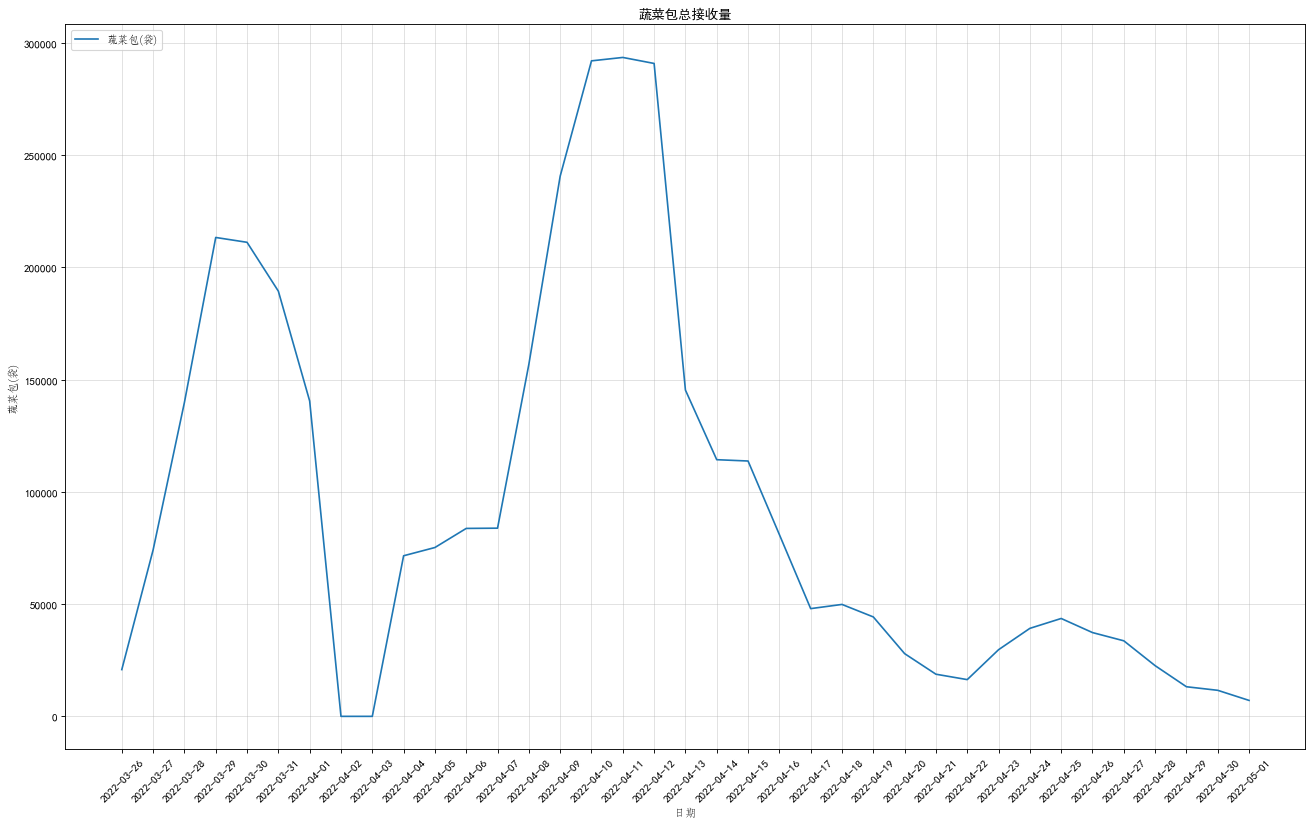

In [26]:
drawingSingBar(allVegatable_fillNan, "蔬菜包总接收量", 'date', 'hjjszcscb', 
                '日期', '蔬菜包(袋)', '蔬菜包(袋)', './pictures/蔬菜包总接收量.png', (20, 12))

发放的蔬菜包总袋数

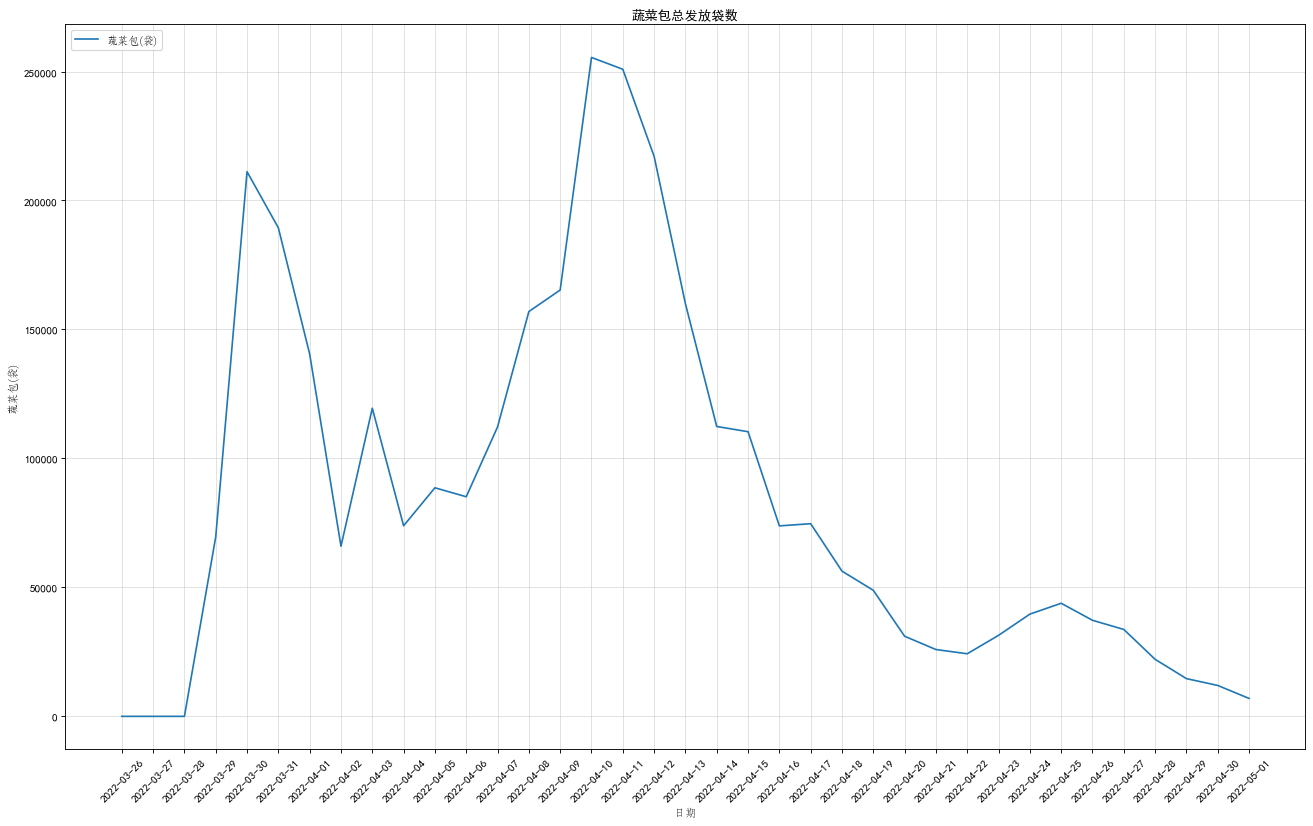

In [27]:
drawingSingBar(allVegatable_fillNan, "蔬菜包总发放袋数", 'date', 'hjffscb', 
                '日期', '蔬菜包(袋)', '蔬菜包(袋)', './pictures/蔬菜包总发放袋数.png', (20, 12))

读取疫情数据

In [28]:
nai = pd.read_csv('./data/1nai.csv', encoding='gb18030')
nalip = pd.read_csv('./data/1nalip.csv', encoding='gb18030')

In [29]:
def processTimeFormat(inputDateframe):
    
    if '日' not in inputDateframe['date']:
        inputDateframe['date'] = inputDateframe['date'] + '日'
    # print(inputDateframe['date'])
    inputDateframe['date'] = datetime.datetime.strptime("2022年" + inputDateframe['date'], "%Y年%m月%d日").strftime("%Y-%m-%d")
    return inputDateframe

In [30]:
# 全市总计新增无症状感染者
nai.rename(columns={'区域':'date', '全市总计':'all'}, inplace=True)
nai_all = nai[['date','all']].copy()
nai_all = nai_all.drop(81)
# print(nai_all)
nai_all = nai_all.apply(processTimeFormat, axis=1)
nai_all = nai_all.fillna(0)
nai_all

,date,all
0,2022-03-04,0.0
1,2022-03-05,0.0
2,2022-03-06,5.0
3,2022-03-07,6.0
4,2022-03-08,10.0
...,...,...
76,2022-05-19,0.0
77,2022-05-20,0.0
78,2022-05-21,0.0
79,2022-05-22,0.0


In [31]:
def processObjectToFloat(inputDataFrame):
    sum = 0
    if '+' in inputDataFrame['all']:
        strlist = inputDataFrame['all'].split('+')
        for x in strlist:
            sum += float(x)
        
        inputDataFrame['all'] = sum
    return inputDataFrame

In [32]:
# 新增本土感染者
nalip.rename(columns={'区域编号':'date', '全市总计':'all'}, inplace=True)
nalip_all = nalip[['date','all']].copy()
nalip_all = nalip_all.apply(processTimeFormat, axis=1)
nalip_all = nalip_all.fillna(0)
# nalip_all[['all']] = nalip_all[['all']].apply(pd.to_numeric)
nalip_all = nalip_all.apply(processObjectToFloat, axis=1)
nalip_all[['all']] = nalip_all[['all']].apply(pd.to_numeric)
print(nalip_all.dtypes)
print(nalip_all)

date     object
all     float64
dtype: object
          date   all
0   2022-03-04   5.0
1   2022-03-05   7.0
2   2022-03-06   7.0
3   2022-03-07  17.0
4   2022-03-08  12.0
..         ...   ...
76  2022-05-19   0.0
77  2022-05-20   0.0
78  2022-05-21   0.0
79  2022-05-22   0.0
80  2022-05-23   0.0

[81 rows x 2 columns]


In [33]:
nalip_all_number = nalip_all.copy()
nai_all_number = nai_all.copy()

将蔬菜输出和病毒数据的日期天数对齐。

In [34]:
allVegatableTemp = allVegatable_fillNan.copy()
addVegatableColumnNameList = VegatableColumnNameList
print(allVegatableTemp.shape)

(37, 18)


In [35]:
topAddRowNameList = createDateList("2022-03-04", "2022-03-25")
bottomAddRowNameList = createDateList("2022-05-02", "2022-05-23")

addVegatableColumnNameList.append('date')
print(len(addVegatableColumnNameList))

18


In [36]:
topAddDF = pd.DataFrame(index=topAddRowNameList, columns=addVegatableColumnNameList)
bottomAddDF = pd.DataFrame(index=bottomAddRowNameList, columns=addVegatableColumnNameList)
print(topAddDF.shape)
allVegatableTemp = pd.concat([topAddDF, allVegatableTemp])
allVegatableTemp = pd.concat([allVegatableTemp, bottomAddDF])
allVegatableTemp.describe()

print(allVegatableTemp.shape)

allVegatableTempjsdraw = allVegatableTemp[['date','hjjszcscb']].fillna(0).copy()
print(allVegatableTempjsdraw.shape)

allVegatableTempffdraw = allVegatableTemp[['date','hjffscb']].fillna(0).copy()
print(allVegatableTempffdraw.shape)

(22, 18)
(81, 18)
(81, 2)
(81, 2)


需要显示数据归一化处理

In [37]:
max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))

nai_all[['all']] = nai_all[['all']].apply(max_min_scaler)
print(nai_all)

nalip_all[['all']] = nalip_all[['all']].apply(max_min_scaler)
print(nalip_all)

allVegatableTempjsdraw[['hjjszcscb']] = allVegatableTempjsdraw[['hjjszcscb']].apply(max_min_scaler)
print(allVegatableTempjsdraw)

allVegatableTempffdraw[['hjjszcscb']] = allVegatableTempffdraw[['hjffscb']].apply(max_min_scaler)
print(allVegatableTempffdraw)


          date       all
0   2022-03-04  0.000000
1   2022-03-05  0.000000
2   2022-03-06  0.001613
3   2022-03-07  0.001935
4   2022-03-08  0.003226
..         ...       ...
76  2022-05-19  0.000000
77  2022-05-20  0.000000
78  2022-05-21  0.000000
79  2022-05-22  0.000000
80  2022-05-23  0.000000

[81 rows x 2 columns]
          date       all
0   2022-03-04  0.002527
1   2022-03-05  0.003537
2   2022-03-06  0.003537
3   2022-03-07  0.008590
4   2022-03-08  0.006064
..         ...       ...
76  2022-05-19  0.000000
77  2022-05-20  0.000000
78  2022-05-21  0.000000
79  2022-05-22  0.000000
80  2022-05-23  0.000000

[81 rows x 2 columns]
           date  hjjszcscb
2022-03-04    0        0.0
2022-03-05    0        0.0
2022-03-06    0        0.0
2022-03-07    0        0.0
2022-03-08    0        0.0
...         ...        ...
2022-05-19    0        0.0
2022-05-20    0        0.0
2022-05-21    0        0.0
2022-05-22    0        0.0
2022-05-23    0        0.0

[81 rows x 2 columns]
       

病毒数据和蔬菜包数据组合在一张图上。

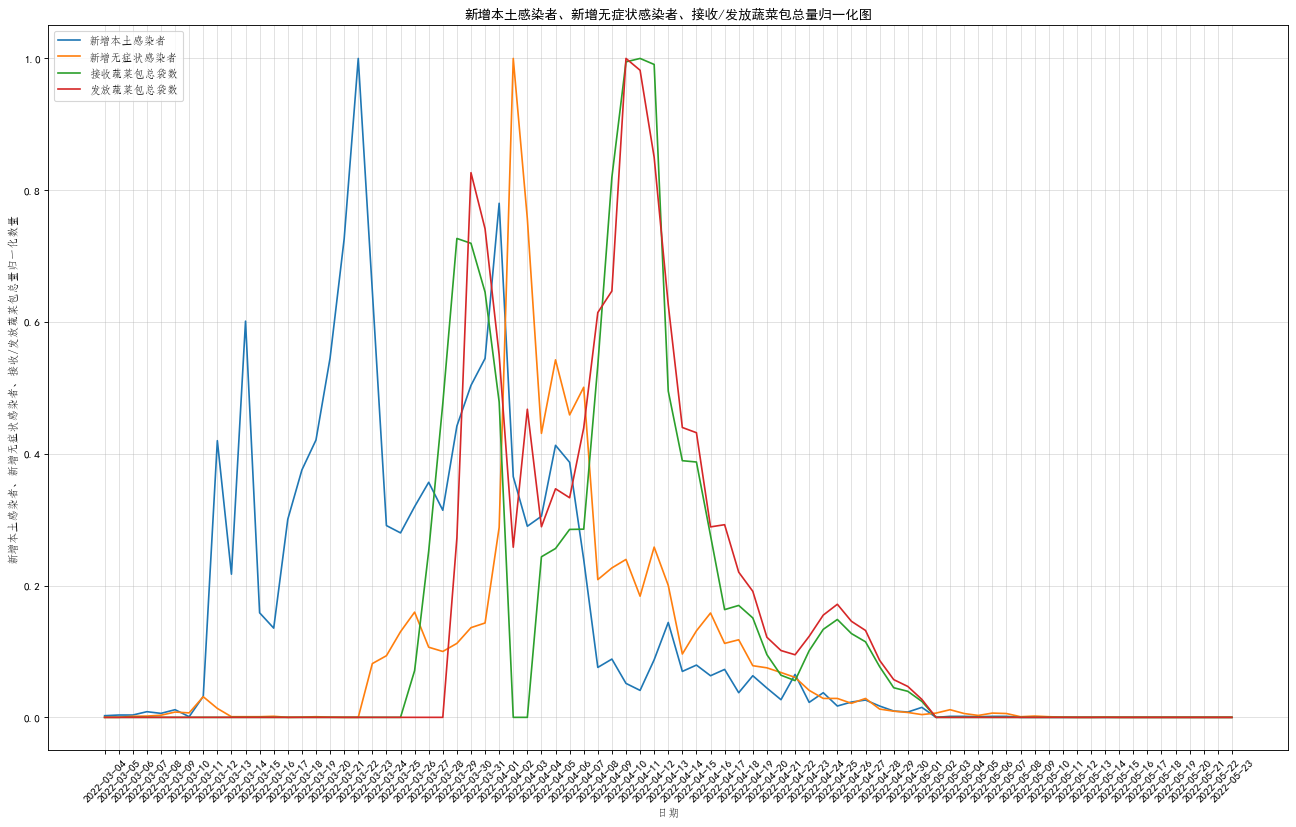

In [38]:

x = nalip_all['date']
y1 = nalip_all['all']
y2 = nai_all['all']
y3 = allVegatableTempjsdraw['hjjszcscb']
y4 = allVegatableTempffdraw['hjjszcscb']
fig = plt.figure(figsize=(20,12), dpi=80)
ax = fig.add_subplot(111)
ax.plot(x, y1, label='新增本土感染者')
ax.plot(x, y2, label='新增无症状感染者')
ax.plot(x, y3, label='接收蔬菜包总袋数')
ax.plot(x, y4, label='发放蔬菜包总袋数')
tick_spacing = 180
plt.xticks(rotation=45)
plt.xlabel('日期', fontproperties=myFont)
plt.ylabel('新增本土感染者、新增无症状感染者、接收/发放蔬菜包总量归一化数量', fontproperties=myFont)
plt.title('新增本土感染者、新增无症状感染者、接收/发放蔬菜包总量归一化图')
plt.grid(alpha=0.4)
plt.legend(prop=myFont, loc='upper left')
plt.savefig('./pictures/NaiNalipVegatableScaler.png')
plt.show()
plt.close()

将所有需要的数据做成一张表
SklcPD_FillNan

In [39]:
# 去掉不能归一化的date列。
SklcPD_FillNan = SklcPD_FillNan.drop('date', axis=1)

In [40]:

SklcPD_FillNan_Scale = SklcPD_FillNan.apply(max_min_scaler)
SklcPD_FillNan_Scale

,gtr,ggr,gike,gdo,gdp,gsd,grs,otr,ogr,oike,...,pdp,psd,prs,vtr,vgr,vike,vdo,vdp,vsd,vrs
2022-03-18,0.979965,1.0,1.000000,0.295720,0.210797,1.000000,1.0,0.968076,1.0,0.961538,...,0.298165,1.0,1.0,1.000000,0.000141,0.930986,0.484866,0.391061,1.0,1.0
2022-03-19,0.978147,1.0,0.992188,0.249027,0.120823,1.000000,1.0,1.000000,1.0,1.000000,...,0.424312,1.0,1.0,0.979495,0.000141,0.890141,0.471853,0.345531,1.0,1.0
2022-03-20,0.973568,1.0,0.992188,0.463035,0.187661,1.000000,1.0,0.984660,1.0,0.961538,...,0.339450,1.0,1.0,0.952635,0.000141,0.866197,0.423762,0.314525,1.0,1.0
2022-03-21,0.972042,1.0,0.992188,0.252918,0.177378,0.952381,1.0,0.984038,1.0,0.961538,...,0.272936,1.0,1.0,0.930571,0.000141,0.812676,0.436775,0.271788,1.0,1.0
2022-03-22,0.972269,1.0,0.992188,0.126459,0.177378,0.952381,1.0,0.983416,1.0,0.961538,...,0.272936,1.0,1.0,0.908807,0.000141,0.928169,0.408204,0.267039,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-19,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2022-05-20,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2022-05-21,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2022-05-22,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [41]:
topAddRowNameList = createDateList("2022-03-04", "2022-03-17")

topSklcPD = pd.DataFrame(index=topAddRowNameList, columns=sklcColoumnNameList)
# topSklcPD

In [42]:
allSklcTemp = pd.concat([topSklcPD, SklcPD_FillNan_Scale])

In [43]:
allSklcTemp = allSklcTemp.fillna(0)
allSklcTemp

,gtr,ggr,gike,gdo,gdp,gsd,grs,otr,ogr,oike,...,pdp,psd,prs,vtr,vgr,vike,vdo,vdp,vsd,vrs
2022-03-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
allVegatableTempffdraw = allVegatableTempffdraw.drop('date', axis=1)
allVegatableTempffdraw

,hjffscb,hjjszcscb
2022-03-04,0.0,0.0
2022-03-05,0.0,0.0
2022-03-06,0.0,0.0
2022-03-07,0.0,0.0
2022-03-08,0.0,0.0
...,...,...
2022-05-19,0.0,0.0
2022-05-20,0.0,0.0
2022-05-21,0.0,0.0
2022-05-22,0.0,0.0


In [45]:
nai_all.rename(columns={'all':'naiAll'}, inplace=True)
nai_all.set_index('date', inplace=True)
nai_all

,naiAll
date,
2022-03-04,0.000000
2022-03-05,0.000000
2022-03-06,0.001613
2022-03-07,0.001935
2022-03-08,0.003226
...,...
2022-05-19,0.000000
2022-05-20,0.000000
2022-05-21,0.000000


In [46]:
nalip_all.rename(columns={'all':'nalipAll'}, inplace=True)
nalip_all.set_index('date', inplace=True)
nalip_all

,nalipAll
date,
2022-03-04,0.002527
2022-03-05,0.003537
2022-03-06,0.003537
2022-03-07,0.008590
2022-03-08,0.006064
...,...
2022-05-19,0.000000
2022-05-20,0.000000
2022-05-21,0.000000


In [47]:
y_data_1 = nai_all.copy()
y_data_2 = nalip_all.copy()

In [48]:
# allSklcTemp   allVegatableTempffdraw  nai_all nalip_all   行是对齐的。合并到一起。

# x_data = pd.concat([allSklcTemp, allVegatableTempffdraw, nai_all[['naiAll']], nalip_all[['nalipAll']] ], axis=1)
x_data = pd.concat([allSklcTemp, allVegatableTempffdraw], axis=1)

x_data

,gtr,ggr,gike,gdo,gdp,gsd,grs,otr,ogr,oike,...,prs,vtr,vgr,vike,vdo,vdp,vsd,vrs,hjffscb,hjjszcscb
2022-03-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
x_data = x_data['2022-03-12':'2022-05-12']
x_data = x_data.drop('2022-03-31', axis=0)
x_data

,gtr,ggr,gike,gdo,gdp,gsd,grs,otr,ogr,oike,...,prs,vtr,vgr,vike,vdo,vdp,vsd,vrs,hjffscb,hjjszcscb
2022-03-12,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2022-03-13,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2022-03-14,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2022-03-15,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2022-03-16,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-08,0.539031,1.0,0.09375,1.000000,0.701799,0.523810,1.0,0.594320,1.0,0.057692,...,1.0,0.078482,0.0,0.121127,0.196040,0.122067,0.142857,1.0,0.0,0.0
2022-05-09,0.532959,1.0,0.09375,0.527237,0.704370,0.523810,1.0,0.579809,1.0,0.057692,...,1.0,0.073745,0.0,0.121127,0.124752,0.101676,0.142857,1.0,0.0,0.0
2022-05-10,0.535881,1.0,0.09375,0.319066,0.694087,0.523810,1.0,0.594113,1.0,0.057692,...,1.0,0.082439,0.0,0.121127,0.080905,0.119832,0.142857,1.0,0.0,0.0
2022-05-11,0.543415,1.0,0.09375,0.289883,0.982005,0.523810,1.0,0.596393,1.0,0.057692,...,1.0,0.072247,0.0,0.121127,0.109477,0.060615,0.142857,1.0,0.0,0.0


In [50]:
x_data.describe()

,gtr,ggr,gike,gdo,gdp,gsd,grs,otr,ogr,oike,...,prs,vtr,vgr,vike,vdo,vdp,vsd,vrs,hjffscb,hjjszcscb
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,...,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,0.547950,0.901639,0.191773,0.315494,0.360656,0.551913,0.901639,0.615308,0.901639,0.258531,...,0.901639,0.240371,0.032798,0.213828,0.291622,0.275817,0.309133,0.901639,48710.590164,0.190676
std,0.227586,0.300273,0.292480,0.196320,0.299324,0.228931,0.300273,0.242425,0.300273,0.299168,...,0.300273,0.261566,0.179554,0.269358,0.239266,0.239812,0.272530,0.300273,68388.033576,0.267703
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.544129,1.000000,0.093750,0.151751,0.082262,0.523810,1.000000,0.583541,1.000000,0.057692,...,1.000000,0.119552,0.000000,0.084507,0.137482,0.122067,0.142857,1.000000,0.000000,0.000000
50%,0.548967,1.000000,0.093750,0.319066,0.339332,0.571429,1.000000,0.614013,1.000000,0.057692,...,1.000000,0.162120,0.000000,0.109437,0.196040,0.199162,0.285714,1.000000,14629.000000,0.057265
75%,0.564099,1.000000,0.109375,0.437743,0.583548,0.571429,1.000000,0.732587,1.000000,0.342308,...,1.000000,0.225253,0.000000,0.201408,0.408204,0.328771,0.285714,1.000000,73895.000000,0.289260
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255462.000000,1.000000


In [51]:
# 无症状人数
y_data_1 = y_data_1['2022-03-12':'2022-05-12']
y_data_1 = y_data_1.drop('2022-03-31', axis=0)

In [52]:
# 本土感染人数
y_data_2 = y_data_2['2022-03-12':'2022-05-12']
y_data_2 = y_data_2.drop('2022-03-31', axis=0)

In [53]:
# 把感人人数相加之后综合成一列数据

# nalip_all_number
# nai_all_number

y_data = nai_all_number.set_index('date').add(nalip_all_number.set_index('date'), fill_value=0).reset_index()
y_data.set_index('date', inplace=True)
y_data = y_data['2022-03-12':'2022-05-12']
y_data = y_data.drop('2022-03-31', axis=0)
y_data[['all']] = y_data[['all']].apply(max_min_scaler)
y_data

,all
date,
2022-03-12,0.228355
2022-03-13,0.113262
2022-03-14,0.312059
2022-03-15,0.082919
2022-03-16,0.071410
...,...
2022-05-08,0.000785
2022-05-09,0.001569
2022-05-10,0.000785


In [54]:
x_data.to_csv('./data/x_data.csv')
y_data.to_csv('./data/y_data.csv')
y_data_1.to_csv('./data/y_data_1.csv')
y_data_2.to_csv('./data/y_data_2.csv')

## 4. 建模

划分数据集

In [55]:
from sklearn.model_selection import train_test_split

import xgboost as xgb
from xgboost import plot_importance

In [56]:
xs_train, xs_test, ys_train, ys_test = train_test_split(x_data, y_data, test_size=0.2, random_state=2020, shuffle=False)


In [57]:
xgbParams = {
    'booster':'gbtree',
    'objective':'reg:linear',
    'gamma':0.1,
    'max_depth':6,
    'lambda':2,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'min_child_weight':3,
    'silent':1,
    'eta':0.1,
    'seed':1000,
    'nthread':4
}

dtrain = xgb.DMatrix(xs_train, ys_train)
plst = list(xgbParams.items())
# print(plst_dw)
num_rounds = 500
# , feature_names=list(x_feature_names)
model_xgb = xgb.train(plst, dtrain, num_rounds)
dtest = xgb.DMatrix(xs_test)
ans = model_xgb.predict(dtest)

DisplayCompletedInfo()

[23:29:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[23:29:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
Completed at 2022-10-08 23:29:51.

-------------------------Completed-------------------------


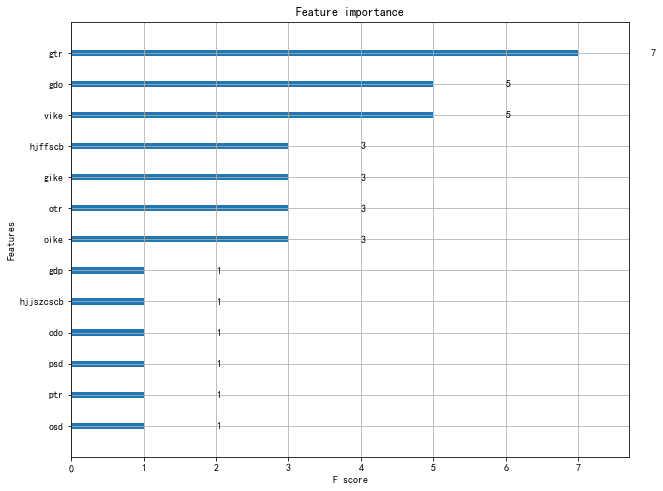

In [58]:
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(model_xgb, max_num_features=40, ax=ax)
# plt.figure(figsize=(96,72), dpi=100)
plt.savefig("./pictures/1xgboost_importance.png")
plt.show()

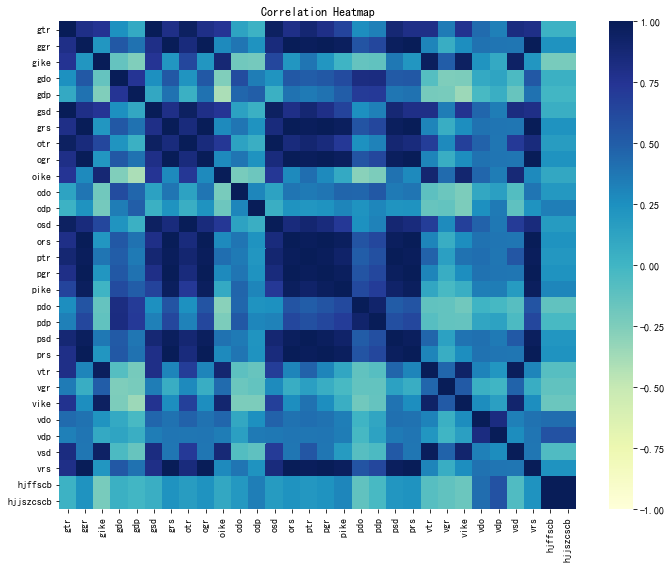

In [59]:
plt.figure(figsize=(10, 8))
fig = sns.heatmap(x_data.corr(), vmin=-1, vmax=1, cmap='YlGnBu') # annot=True, 
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("./pictures/1correlation_heatmap.jpg")

第一问的另外一种思路：
当时好像说的是做类似股票买入卖出点的判断的。用LSTM或者encode decode模型。 

## 5. 第二问

将地址信息读取进来。

In [60]:
pndpl = pd.read_csv('./data/2pndpl.csv', encoding='gb18030')
dmced = pd.read_csv('./data/3dmced.csv', encoding='gb18030')
tind = pd.read_csv('./data/3tind.csv', encoding='gb18030')
tird = pd.read_csv('./data/3tird.csv', encoding='gb18030')

In [61]:
pndpl

,区域名称,隔离人口数（万人）,生活物资投放点数量
0,朝阳区,57.8,94
1,南关区,48.9,261
2,宽城区,32.6,181
3,绿园区,38.5,470
4,二道区,42.6,9
5,长春新区(高新),36.8,215
6,经开区,20.3,37
7,净月区,22.8,279
8,汽开区,21.7,10


In [62]:
locate = pndpl['区域名称'].tolist()
peoples = pndpl['隔离人口数（万人）'].tolist()
deliveryPoints = pndpl['生活物资投放点数量'].tolist()
list1 = [[locate[i], peoples[i]] for i in range(len(locate))]
map_1 = Map()
map_1.set_global_opts(
    title_opts=opts.TitleOpts(title="长春市隔离人口数"),
    visualmap_opts=opts.VisualMapOpts(max_=2500)  #最大数据范围
    )
map_1.add("长春市隔离人口数", list1, maptype="长春")
map_1.render('./data/peoplesMap.html')


list2 = [[locate[i], deliveryPoints[i]] for i in range(len(locate))]
map_2 = Map()
map_2.set_global_opts(
    title_opts=opts.TitleOpts(title="长春市生活物资投放点数量"),
    visualmap_opts=opts.VisualMapOpts(max_=2500)  #最大数据范围
    )
map_2.add("长春市隔离人口数", list2, maptype="长春")
map_2.render('./data/deliveryPointsMap.html')


'f:\\codespace\\HuaweiCupCompetition2022\\data\\deliveryPointsMap.html'

In [63]:
dmced

,小区编号,小区栋数,小区户数（户）,小区人口数（人）,小区横坐标,小区纵坐标,街道编号,所属区域
0,1,11,1060,2417,57.90250,62.132333,C0035,宽城区
1,2,37,4171,9080,51.79225,61.606667,C0048,宽城区
2,3,3,480,1333,54.80225,54.881000,C0010,宽城区
3,4,19,1093,2658,54.21575,67.842333,C0053,宽城区
4,5,15,1330,3033,56.73050,61.479333,C0035,宽城区
...,...,...,...,...,...,...,...,...
1404,1405,5,231,908,25.50975,34.506333,I0032,汽开区
1405,1406,4,267,744,35.64725,40.527333,I0008,汽开区
1406,1407,2,185,727,26.07375,36.628333,I0008,汽开区
1407,1408,3,115,320,33.62550,36.866000,I0008,汽开区


In [64]:
geolocator = Nominatim(user_agent="geoapiExercises")

def transforLongLatToString(longitude, latitude):
    longitude = str(longitude)
    latitude = str(latitude)
    location = geolocator.reverse(latitude + "," + longitude)
    address = location.raw['address']
    
    if "amenity" in address:
        if "suburb" in address:
            script = "{}{}{}{}{}号{}".format(address['state'],address['city'],address['suburb'],
                                   address['road'],address['house_number'],address['amenity'])
        elif "house_number" in address:
            script = "{}{}{}{}{}号{}".format(address['state'],address['city'],address['road'],
                                            address['house_number'],address['amenity'])
        else:
            script = "{}{}{}{}".format(address['state'],address['city'],address['road'],address['amenity'])
    elif "house_number" in address:
        script = "{}{}{}{}{}号".format(address['state'],address['city'],address['suburb'],
                                   address['road'],address['house_number'])
    elif "road" in address:
        if "suburb" in address:
            script = "{}{}{}{}".format(address['state'],address['city'],address['suburb'],
                                   address['road'])
        else:
            script = "{}{}{}".format(address['state'],address['city'],address['road'])
    elif "suburb" in address:
        script = "{}{}{}".format(address['state'],address['city'],address['suburb'])
    else:
        script = "{}{}".format(address['state'],address['city'])
    # print(address)
    # script = "{}{}{}{}".format(address['state'],address['city'],address['suburb'],address['road'])
    time.sleep(1)
    return script

In [65]:
dmced['address'] = ""

for index, row in dmced.iterrows():
    print(index)
    dmced.iat[index,8] = transforLongLatToString(row['longitude'], row['latitude'])


0


KeyError: 'longitude'

具体思路：
1. 确立以虚拟坐标系为准的空间结构。
2. 使用“交通路口节点数据”中的数据建立节点。
3. 使用“交通路口路线数据”中的数据建边。
4. 使用“各区主要小区数据”中的数据设置为节点的特征。这里需要定义一个空间距离超参数。$\Delta l$